The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 0.9137 and the minimum is 0.0000
The mean value of the pixels is 0.4094 and the standard deviation is 0.2722


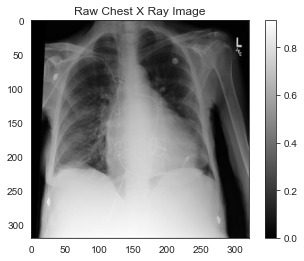

1/1 [==============================] - 4s 4s/step
Predictions: [[0.96908945 0.25876015 0.45692036 0.46812713 0.2195355  0.19905019
  0.11572602 0.36541006 0.12948126 0.26913345 0.15198068 0.16701566
  0.3673816  0.26703146]]
Predicted diseases: ['Atelectasis']


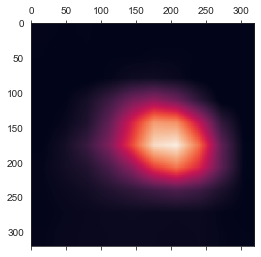

In [2]:
import numpy as np
import tensorflow as tf
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras.backend as K


labels = [ 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
          'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule',  'Pleural_Thickening', 'Pneumonia', 
          'Pneumothorax'] 


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            loss += - pos_weights[i] * K.mean(y_true[:, i] * K.log(y_pred[:, i] + epsilon)) \
                    - neg_weights[i] * K.mean((1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
        return loss
    return weighted_loss


def load_C3M3_model(pos_weights, neg_weights):
    num_classes = len(labels)
    base_model = DenseNet121(weights="D:/Xray_Data/data/small_data/nih/densenet.hdf5", include_top=False)  #1 Densnet.hdf5 file
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(num_classes, activation="sigmoid")(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights))
    model.load_weights("D:/Xray_Data/data/small_data/nih/pretrained_model.h5")    #2 pretrained_model.h5 file
    return model


def preprocess_image(image_path, target_size=(320, 320)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img.convert('L'))  
    img = np.stack((img,)*3, axis=-1)  
    img = img / 255.0  
    img = np.expand_dims(img, axis=0)  
    return img


def display_image_statistics(img):
    sns.set_style("white")
    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.colorbar()
    plt.title('Raw Chest X Ray Image')
    print(f"The dimensions of the image are {img.shape[1]} pixels width and {img.shape[2]} pixels height")
    print(f"The maximum pixel value is {img.max():.4f} and the minimum is {img.min():.4f}")
    print(f"The mean value of the pixels is {img.mean():.4f} and the standard deviation is {img.std():.4f}")
    plt.show()


def generate_grad_cam(model, img, layer_name, cls=-1):
    grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        if cls == -1:
            cls = np.argmax(predictions[0])
        loss = predictions[:, cls]
    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]
    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = gate_f * gate_r * grads
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.zeros(output.shape[0:2], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]
    cam = cv2.resize(cam.numpy(), (img.shape[2], img.shape[1]))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    return heatmap


image_path = "F:/working_diseases/cardiomegaly.png"   #3 image Path
img = preprocess_image(image_path)


pos_weights = np.array([1.0] * len(labels)) 
neg_weights = np.array([1.0] * len(labels)) 


model = load_C3M3_model(pos_weights, neg_weights)


display_image_statistics(img)


predictions = model.predict(img)
print("Predictions:", predictions)

threshold = 0.5
predicted_labels = [labels[i] for i, pred in enumerate(predictions[0]) if pred > threshold]
print("Predicted diseases:", predicted_labels)


layer_name = 'conv5_block16_concat'
heatmap = generate_grad_cam(model, img, layer_name)
plt.matshow(heatmap)
plt.show()
